In [1]:
import sys
sys.path.append("/Users/arames52/bcg_dust_continuum/src/")
import glob
import statmorph
import photutils
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import scipy.ndimage as ndi
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.visualization import simple_norm, ZScaleInterval, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch, SqrtStretch
from statmorph.utils.image_diagnostics import make_figure
# import warnings
# from astropy.wcs import FITSFixedWarning
# warnings.filterwarnings('ignore', category=FITSFixedWarning)
# from astropy.coordinates import Angle
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import pickle

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [66]:
# Paths

des_catalog_path = "/Users/arames52/bcg_dust_continuum/notebook/data/Catalogs/des_catalog.pkl"
swire_catalog_path = "/Users/arames52/bcg_dust_continuum/notebook/data/Catalogs/SWIRE_catalog/"
herschel_catalog_path = "/Users/arames52/bcg_dust_continuum/notebook/data/Catalogs/herschel_catalog/"
alma_catalog_path = "/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/natural_imfit_results.pkl"
bcg_redshift_path = "/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/BCG_redshifts.xlsx"
bcg_coordinates_path = "/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/bcg_regions.txt"


In [69]:
mag_cols = ['mag_auto_g', 'mag_auto_r', 'mag_auto_i', 'mag_auto_z','mag_auto_y']
magerr_cols = ['magerr_auto_g', 'magerr_auto_r', 'magerr_auto_i','magerr_auto_z', 'magerr_auto_y']
swire_columns = ['ra','dec','flux_kr_36', 'uncf_kr_36','flux_kr_45',
    'uncf_kr_45', 'flux_kr_58', 'uncf_kr_58', 'flux_kr_80', 'uncf_kr_80',
    'flux_kr_24','uncf_kr_24']
hermes_columns = ['ra', 'dec', 'F24', 'e_F24', 'F250', 'et_F250', 'F350', 'et_F350', 'F500', 'et_F500']

cigale_columns = ['id', 'redshift', 'des_g', 'des_r', 'des_i', 'des_z', 'des_Y',
       'des_g_err', 'des_r_err', 'des_i_err', 'des_z_err', 'des_Y_err',
       'spitzer.irac.ch1', 'spitzer.irac.ch1_err', 'spitzer.irac.ch2',
       'spitzer.irac.ch2_err', 'spitzer.irac.ch3', 'spitzer.irac.ch3_err',
       'spitzer.irac.ch4', 'spitzer.irac.ch4_err', 'spitzer.mips.24',
       'spitzer.mips.24_err', 'herschel.spire.PSW', 'herschel.spire.PSW_err',
       'herschel.spire.PMW', 'herschel.spire.PMW_err', 'herschel.spire.PLW',
       'herschel.spire.PLW_err', 'ALMA', 'ALMA_err']


In [35]:
def catalog_matching(c, df):

    ra = np.array(df['ra']) * u.degree
    dec = np.array(df['dec']) * u.degree
    catalog = SkyCoord(ra, dec, frame = 'icrs')
    idx, d2d, d3d = c.match_to_catalog_sky(catalog)
    idx_all = c.separation(catalog) < 0.007*u.deg
    match = pd.DataFrame(df.iloc[idx]).T.reset_index(drop = True)
    nearest_neighbours = pd.DataFrame(df.iloc[idx_all]).reset_index(drop=True)

    return match, nearest_neighbours

def mag_to_mJy(mag):
    return 10**((8.90 - mag)/2.5)*1000

def bcg_regions_load():
    file = 
    bcg_regions = pd.read_csv(file, delimiter=',')
    return bcg_regions

In [196]:
def multiwavelength_catalog(bcg_name):

    bcg_coordinates = bcg_regions_load()
    bcg_info = bcg_coordinates[bcg_coordinates['id'] == bcg_name]
    with open(des_catalog_path, "rb") as f:
        des_catalog = pickle.load(f)
    des_df = des_catalog[bcg_name]
    ra = bcg_info['ra'].values[0]
    dec = bcg_info['dec'].values[0]

    c = SkyCoord(ra * u.degree, dec * u.degree, frame  ='icrs')
    des_match, des_nn = catalog_matching(c, des_df)
    des_fluxes = des_match[['ra', 'dec']].copy()
    for err_col,col in zip(magerr_cols, mag_cols):
        des_fluxes[col] = mag_to_mJy(des_match[col])
        des_fluxes[err_col] = des_match[err_col]*des_fluxes[col]
    
    des_fluxes = des_fluxes.rename(columns = {"mag_auto_g":"des_g", "magerr_auto_g": "des_g_err", "mag_auto_r": "des_r", "magerr_auto_r": "des_r_err",
                     "mag_auto_i": "des_i", "magerr_auto_i":"des_i_err", "mag_auto_z":"des_z", "magerr_auto_z":"des_z_err",
                     "mag_auto_y":"des_Y", "magerr_auto_y": "des_Y_err"})

    swire_df = pd.read_csv(swire_catalog_path + bcg_name + ".csv")
    swire_df = swire_df[swire_columns]
    swire_match, swire_nn = catalog_matching(c, swire_df)
    swire_match = pd.concat([swire_match[swire_columns[:2]], swire_match[swire_columns[2:]].mul(0.001)], axis = 1)
    swire_match = swire_match.rename(columns = {"flux_kr_36":"spitzer.irac.ch1", "uncf_kr_36": "spitzer.irac.ch1_err",
    "flux_kr_45": "spitzer.irac.ch2", 'uncf_kr_45': "spitzer.irac.ch2_err", 'flux_kr_58': "spitzer.irac.ch3", 'uncf_kr_58': "spitzer.irac.ch3_err", 
    'flux_kr_80': "spitzer.irac.ch4", 'uncf_kr_80': "spitzer.irac.ch4_err"})
    
    if bcg_name.startswith('CDFS'):
        hermes_file = "/Users/arames52/bcg_dust_continuum/notebook/data/catalogs/herschel_catalog/L5-CDFS-SWIRE_xID24-DR3/L5-CDFS-SWIRE_xID24_DR3.fits"
    elif bcg_name.startswith('ES1'):
        hermes_file = "/Users/arames52/bcg_dust_continuum/notebook/data/catalogs/herschel_catalog/L6-ELAIS-S1-SWIRE_xID24-DR3/L6-ELAIS-S1-SWIRE_xID24_DR3.fits"
    else:
        hermes_file = "/Users/arames52/bcg_dust_continuum/notebook/data/catalogs/herschel_catalog/L6-XMM-LSS-SWIRE_xID24-DR3/L6-XMM-LSS-SWIRE_xID24_DR3.fits"
    hermes_hdu = fits.open(hermes_file)
    hermes_df = Table(hermes_hdu[1].data).to_pandas()
    hermes_df = hermes_df.rename(columns={'RA':'ra', 'Dec':'dec'})
    
    hermes_match, hermes_nn = catalog_matching(c, hermes_df)
    hermes_match = hermes_match[hermes_columns]

    hermes_match['F24'] = hermes_match['F24'].apply(lambda x: x*0.001)
    hermes_match['e_F24'] = hermes_match['e_F24'].apply(lambda x: x*0.001)
    hermes_match = hermes_match.rename(columns = {"F24":"spitzer.mips.24", "e_F24": "spitzer.mips.24_err", "F250": "herschel.spire.PSW", 
    "et_F250": "herschel.spire.PSW_err","F350": "herschel.spire.PMW", "et_F350":"herschel.spire.PMW_err", 
    "F500": "herschel.spire.PLW", "et_F500":"herschel.spire.PLW_err"})

    # print(des_fluxes)

    with open(alma_catalog_path, "rb") as f:
        alma_flux_results = pickle.load(f)

    alma_flux_bcg = alma_flux_results[bcg_name]['deconvolved']['component0']['flux']

    redshift_info = pd.read_excel(bcg_redshift_path)
    redshift = redshift_info[redshift_info['bcg'] == bcg_name]['redshift'].values[0]
    mw_flux_dict = {"id":bcg_name, "redshift":redshift}
    for col in cigale_columns[2:12]:
        mw_flux_dict[col] = des_fluxes[col].values[0]
    for col in cigale_columns[12:20]:
        mw_flux_dict[col] = swire_match[col].values[0]
    for col in cigale_columns[20:28]:
        mw_flux_dict[col] = hermes_match[col].values[0]
    
    mw_flux_dict['ALMA'] = alma_flux_bcg['value'][0] * 1000
    mw_flux_dict['ALMA_err'] = alma_flux_bcg['error'][0] * 1000

    

    return mw_flux_dict

In [199]:
mw_catalog = multiwavelength_catalog("CDFS-18")

In [201]:
mw_catalog

{'id': 'CDFS-18',
 'redshift': 0.80758,
 'des_g': 0.0019982729062571055,
 'des_r': 0.007053599548742232,
 'des_i': 0.01998107270159639,
 'des_z': 0.03301818526291068,
 'des_Y': 0.036703408725543854,
 'des_g_err': 0.00014887676681845936,
 'des_r_err': 0.00019460007919355684,
 'des_i_err': 0.00036800628186339074,
 'des_z_err': 0.0007109642722827358,
 'des_Y_err': 0.002442196001064083,
 'spitzer.irac.ch1': 0.15938999999999998,
 'spitzer.irac.ch1_err': 0.00167,
 'spitzer.irac.ch2': 0.127,
 'spitzer.irac.ch2_err': 0.0019399999999999999,
 'spitzer.irac.ch3': 0.12758,
 'spitzer.irac.ch3_err': 0.00605,
 'spitzer.irac.ch4': 0.09359,
 'spitzer.irac.ch4_err': 0.00608,
 'spitzer.mips.24': 0.43535,
 'spitzer.mips.24_err': 0.01715,
 'herschel.spire.PSW': 22.873264,
 'herschel.spire.PSW_err': 3.8139908,
 'herschel.spire.PMW': 5.338831,
 'herschel.spire.PMW_err': 5.6966114,
 'herschel.spire.PLW': nan,
 'herschel.spire.PLW_err': 12.708551,
 'ALMA': 4.208578680038455,
 'ALMA_err': 0.057017642883375956}

In [207]:
pd.DataFrame(mw_catalog, index=[0])

,id,redshift,des_g,des_r,des_i,des_z,des_Y,des_g_err,des_r_err,des_i_err,...,spitzer.mips.24,spitzer.mips.24_err,herschel.spire.PSW,herschel.spire.PSW_err,herschel.spire.PMW,herschel.spire.PMW_err,herschel.spire.PLW,herschel.spire.PLW_err,ALMA,ALMA_err
0,CDFS-18,0.80758,0.001998,0.007054,0.019981,0.033018,0.036703,0.000149,0.000195,0.000368,...,0.43535,0.01715,22.873264,3.813991,5.338831,5.696611,NaN,12.708551,4.208579,0.057018


In [185]:
import sys
sys.path.append("/Users/arames52/bcg_dust_continuum/src/")
import bcg_parameter_file as p
import helper_functions as hf
import data_ingestion as di
import glob
import statmorph
import photutils
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import scipy.ndimage as ndi
from astropy.wcs import WCS
from scipy import stats
from math import *
from numpy import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.visualization import simple_norm, ZScaleInterval, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch, SqrtStretch
from statmorph.utils.image_diagnostics import make_figure
import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)
from astropy.coordinates import Angle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
from regions import PixCoord
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion
from regions import CircleSkyRegion, CirclePixelRegion
from ast import literal_eval
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import matplotlib
plt.style.use(['science'])
import pickle
from astropy.wcs.utils import skycoord_to_pixel
import ast
from matplotlib import animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import figure, cm
from photutils.aperture import SkyCircularAperture
from photutils.aperture import aperture_photometry
from os.path import exists
plt.rcParams.update({'figure.max_open_warning': 1000})

image_path = "/Users/arames52/bcg_dust_continuum/notebook/data/MW_images/ALMA_images/"

In [187]:
def read_alma_fits(file):
    hdu = fits.open(file)[0]
    header = hdu.header
    data = hdu.data[0,0,:,:]
    wcs = WCS(header, naxis = 2)
    data = np.nan_to_num(data)
    return data,header,wcs

def image_cutout(file, size_in_arcsec):
    data,header,wcs = read_alma_fits(file)
    ra, dec = header['CRVAL1'], header['CRVAL2']
    position = SkyCoord(ra, dec, frame = 'fk5', unit = 'deg')
    s = size_in_arcsec
    size = u.Quantity((s,s), u.arcsec)
    cutout = Cutout2D(data, position = position, size = size, wcs = wcs)
    return cutout

In [188]:
def compute_sersic(bcg_name):

    file = glob.glob(image_path + bcg_name +"*.fits")[0]
    data, header, wcs = read_alma_fits(file)
    bmaj = header['BMAJ']*u.deg
    bmin = header['BMIN']*u.deg
    bpa = u.Quantity(header['BPA'], unit = "deg")
    cdelt = header['CDELT2']*u.deg
    x_sigma = bmin/cdelt
    y_sigma = bmaj/cdelt
    psf = Gaussian2DKernel(x_stddev=x_sigma*gaussian_fwhm_to_sigma, y_stddev=y_sigma*gaussian_fwhm_to_sigma, theta = bpa)
    image = image_cutout(file, 8).data   
    weightmap = np.full(image.shape, 2e-5)
    threshold = 2*2e-5
    segm = photutils.detect_sources(image, threshold, npixels = 5)
    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = np.int64(segmap_float > 0.5)
    source_morphs = statmorph.source_morphology(image, segmap, weightmap = weightmap)
    morph = source_morphs[0]

    return morph

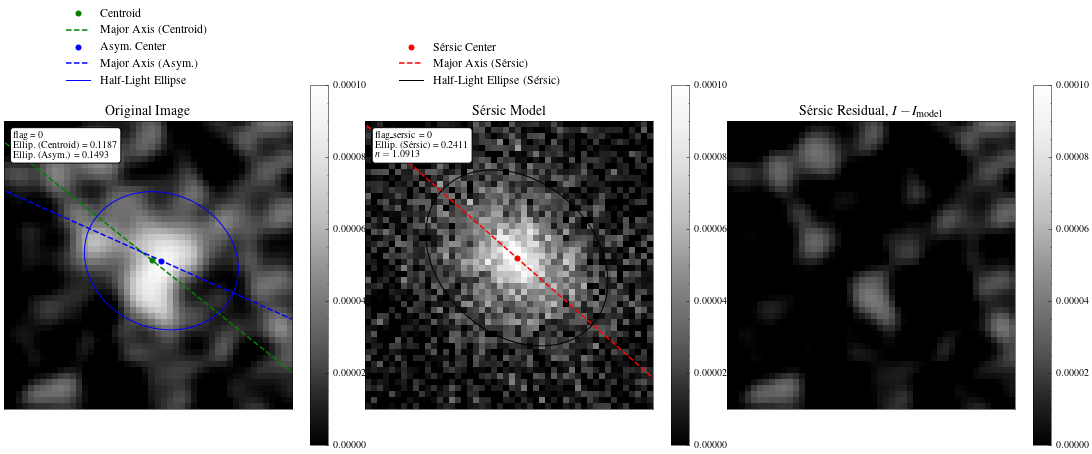

In [190]:
morph = compute_sersic("ES1_z_0.99")
fig = make_figure(morph)
# fig.suptitle("ES1_z_1.65", x = 0.8)

In [194]:
def save_sersic_results():
    sersic_profile = {}
    good_detections = ["CDFS-18", "ES1-18", "ES1-25", "ES1_z_0.99","ES1_z_0.99b","ES1_z_1.04","ES1_z_1.38","ES1_z_1.40",
"ES1_z_1.60", "ES1_z_1.65", "ES1_z_1.70", "XMM-113", "XMM-29", "XMM-30", "XMM_z_0.9", "XMM_z_1.0"]
    for bcg in good_detections:
        morph = compute_sersic(bcg)
        fig = make_figure(morph)
        fig.suptitle(bcg, x = 0.8)
        fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/" + bcg + "_sersic.png", dpi = 300)
        sersic_profile[bcg] = (morph.sersic_n, morph.sersic_rhalf * 0.045)
    return sersic_profile


{'CDFS-18': (0.517900702959268, 0.3234972249750695),
 'ES1-18': (0.9002263317116567, 0.6375488449350732),
 'ES1-25': (0.6921047831881519, 0.6691584791708564),
 'ES1_z_0.99': (1.0913055654857096, 0.7564233662553768),
 'ES1_z_0.99b': (1.2567262701761712, 0.7159313072309245),
 'ES1_z_1.04': (1.234250764422008, 0.7519617532761311),
 'ES1_z_1.38': (0.898204726828569, 0.3838058913994024),
 'ES1_z_1.40': (0.9469692953472915, 0.4520922346595077),
 'ES1_z_1.60': (0.9021332731420164, 0.456607053914986),
 'ES1_z_1.65': (0.7857547112456803, 0.38570209382849796),
 'ES1_z_1.70': (0.5828426492959523, 0.4920817139716297),
 'XMM-113': (1.4695521150284603, 0.7675831311186924),
 'XMM-29': (0.624402514059679, 0.5932487685866871),
 'XMM-30': (0.3893268752386015, 0.5092209344285583),
 'XMM_z_0.9': (1.004919654716117, 1.0115600097540063),
 'XMM_z_1.0': (0.6653306535881347, 0.3571189959245823)}

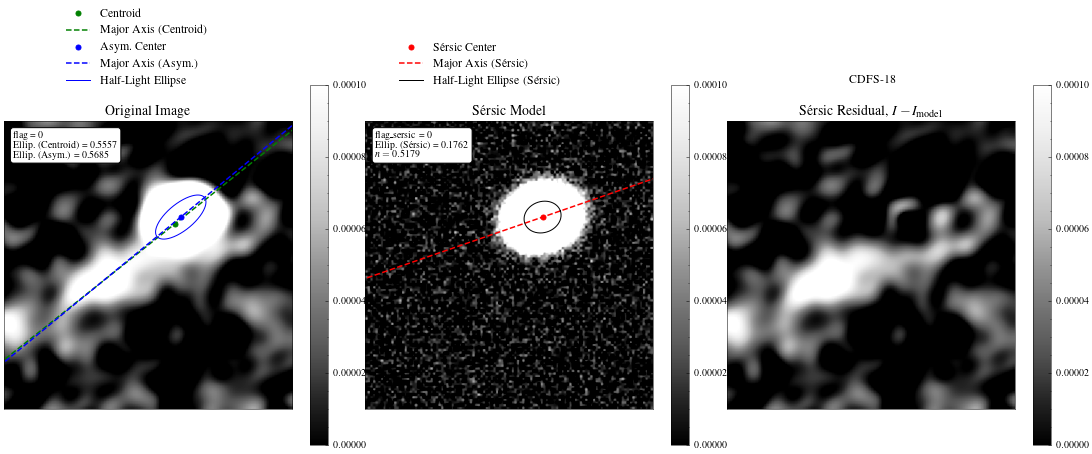

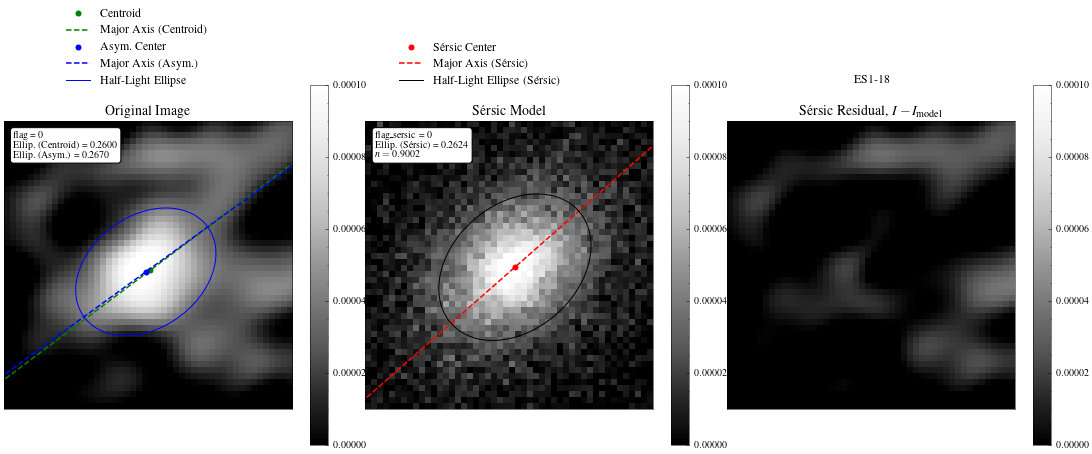

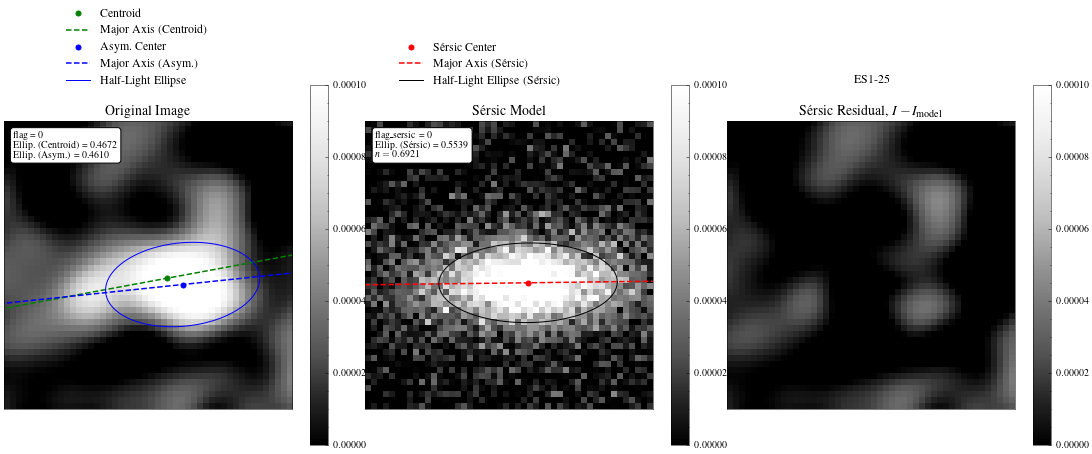

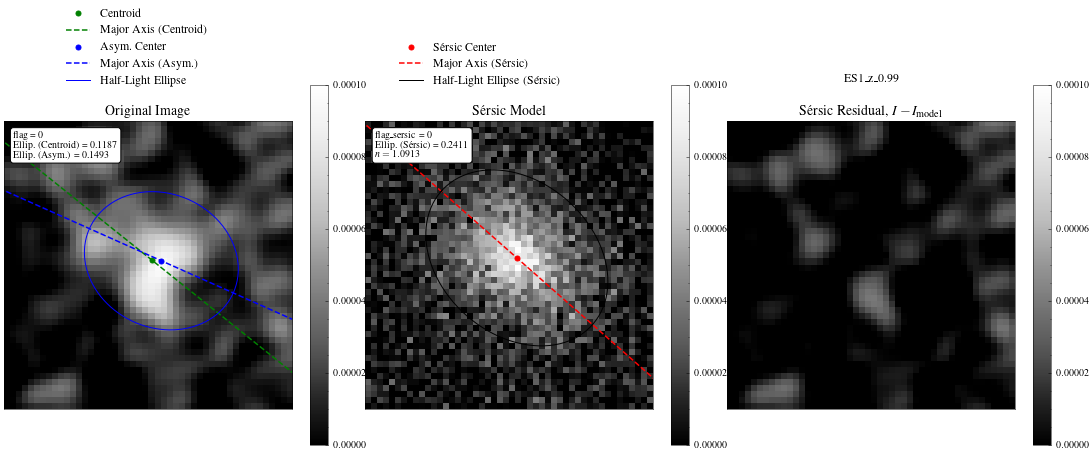

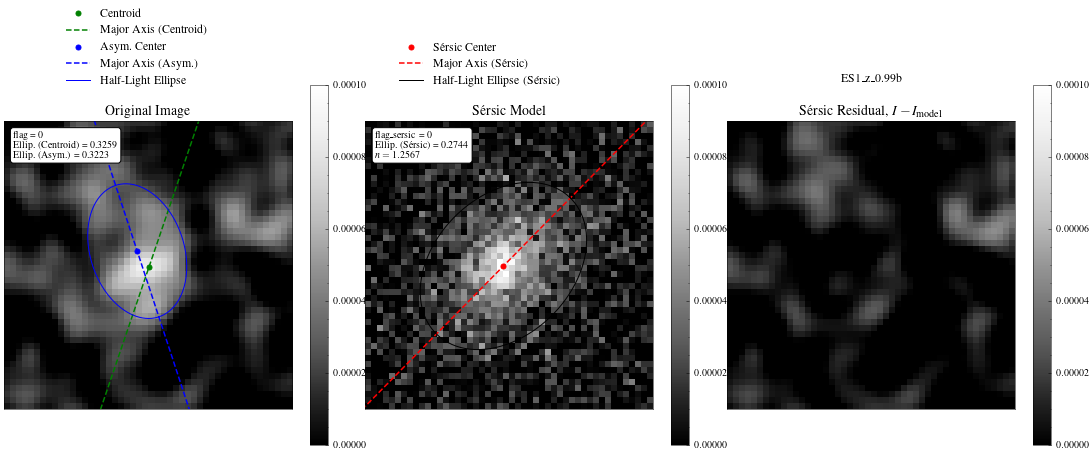

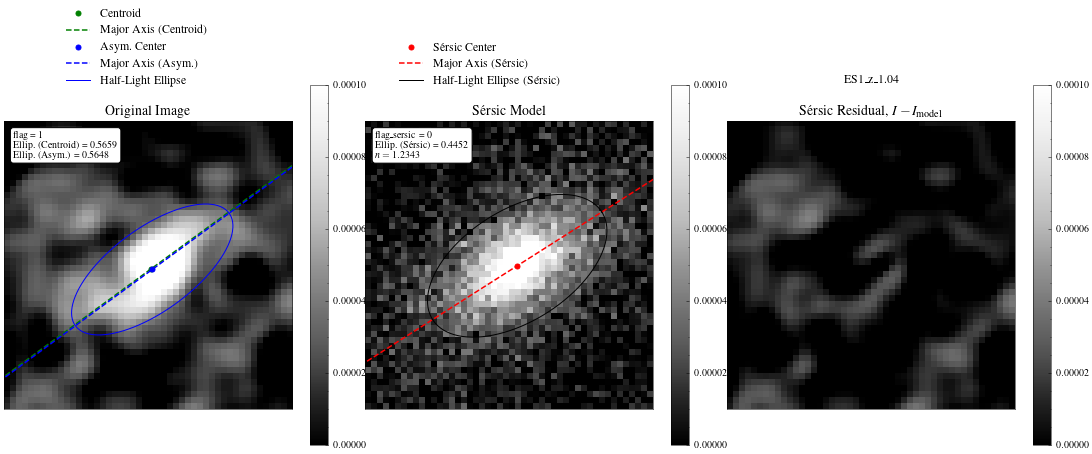

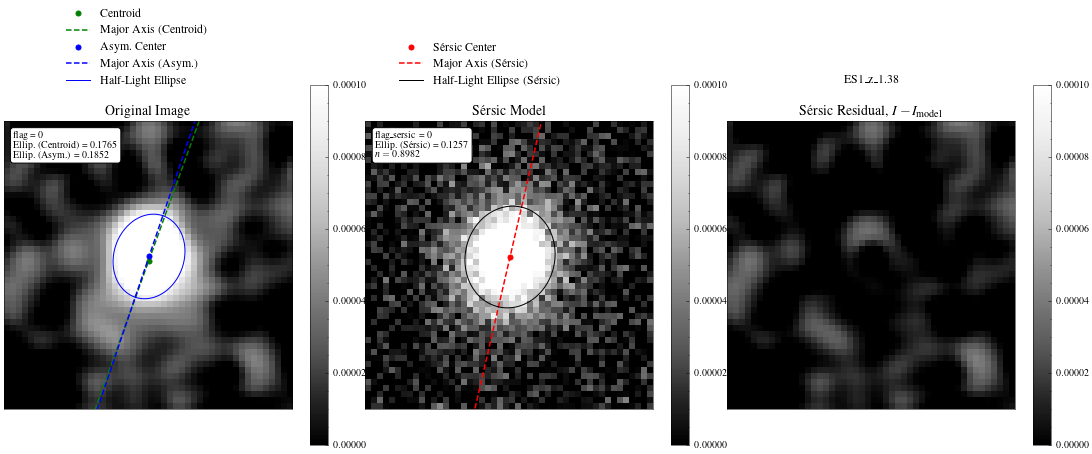

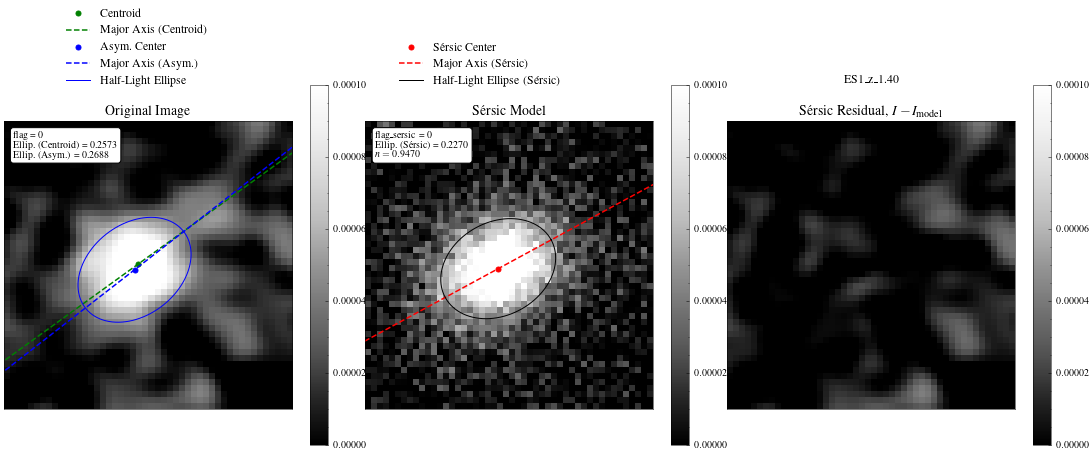

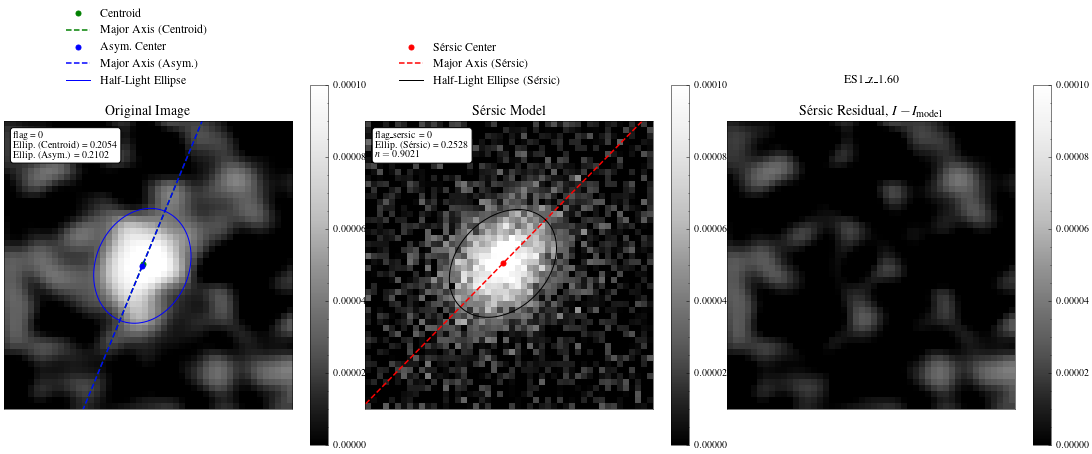

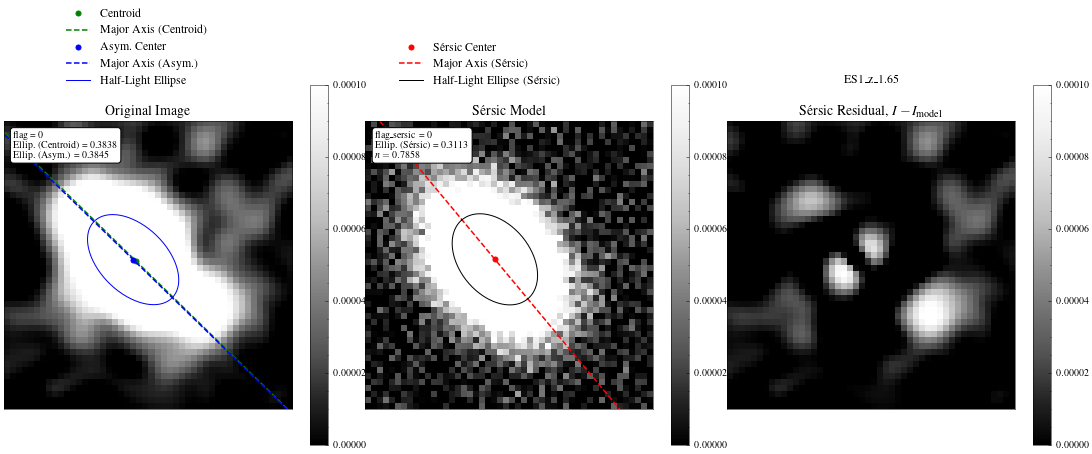

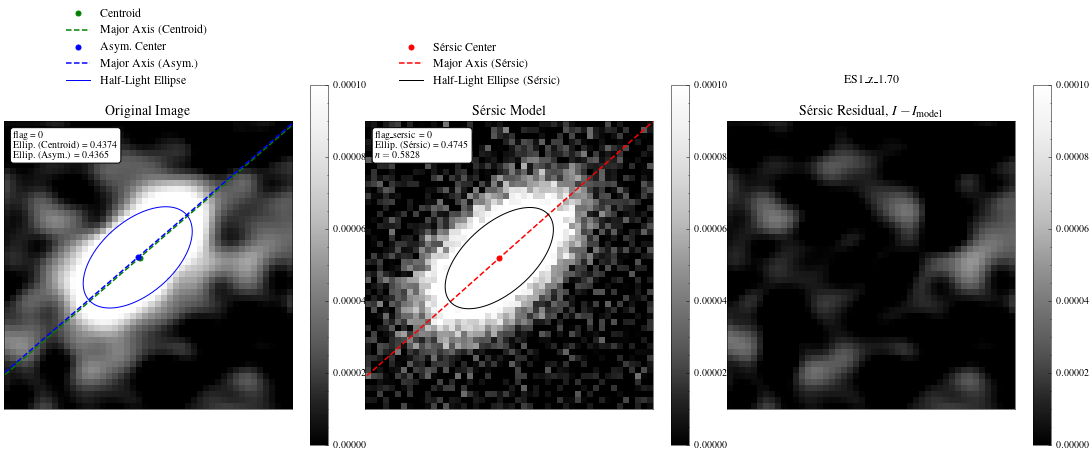

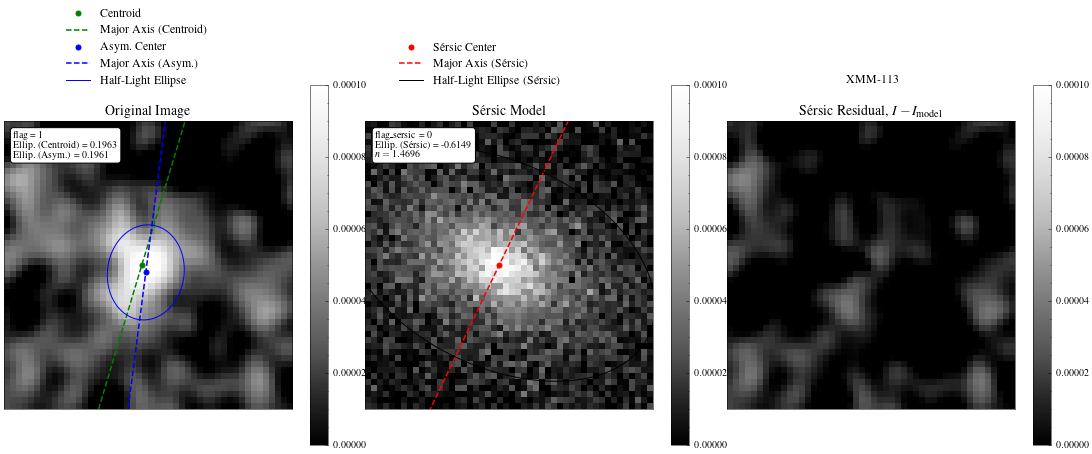

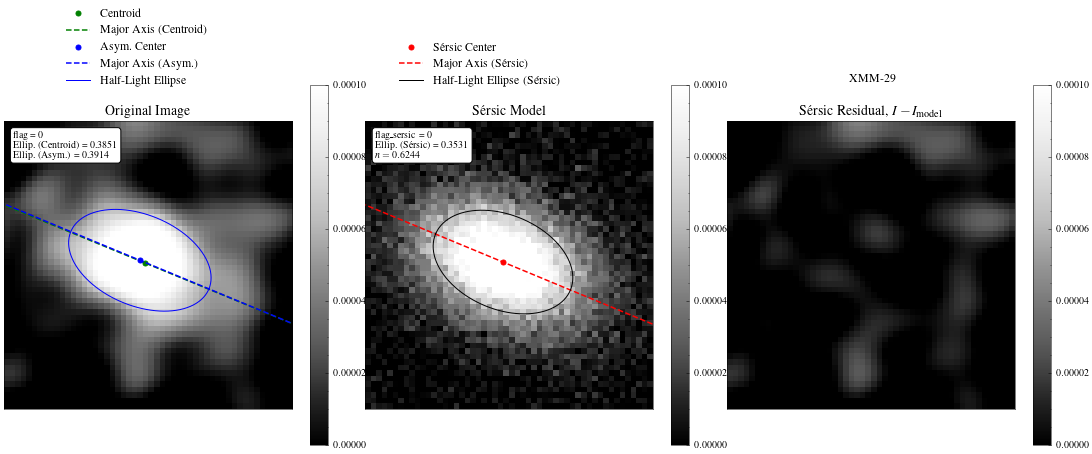

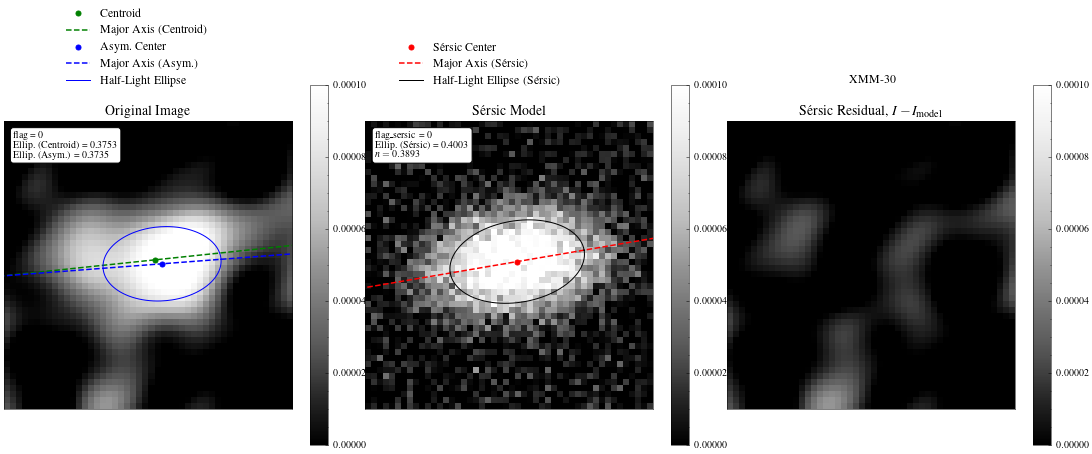

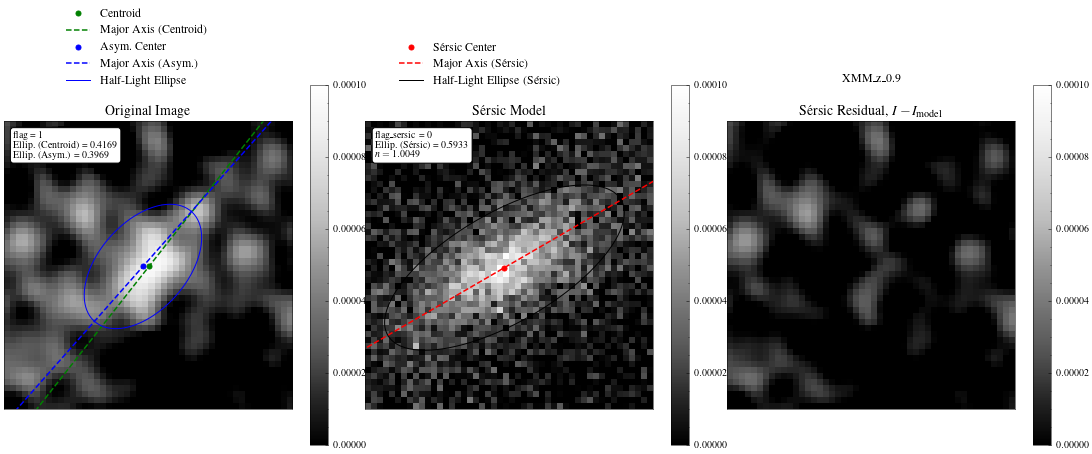

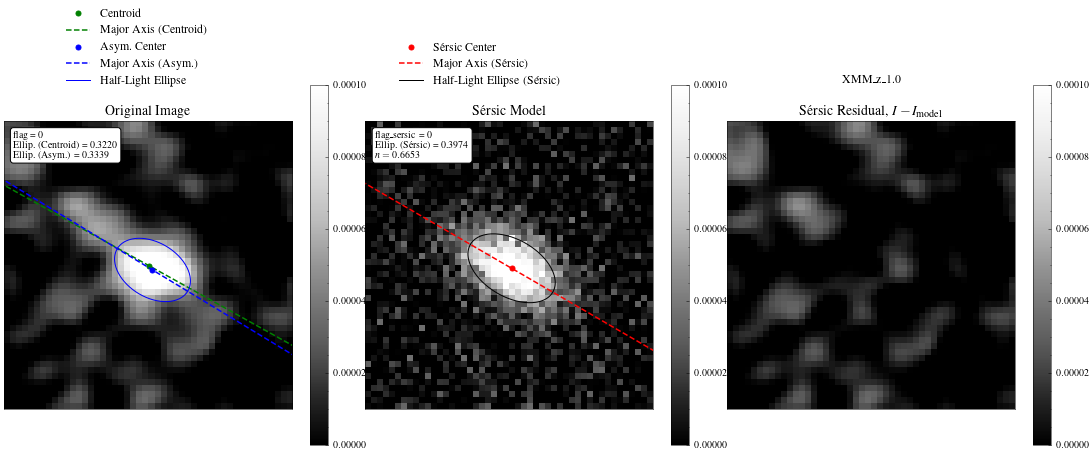

In [195]:
sersic_profile_results = save_sersic_results()

In [217]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
from decimal import *
import pandas as pd
from math import *
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii
import glob
import os
import matplotlib.pyplot as plt
import matplotlib

all_bcgs = ['CDFS-18',
 'CDFS19',
 'ES1-12',
 'ES1-18',
 'ES1-25',
 'ES1-26',
 'ES1-34',
 'ES1-35',
 'XMM-11',
 'XMM-19',
 'XMM-27',
 'XMM-29',
 'XMM-30',
 'ES1_z_0.88',
 'ES1_z_0.99',
 'ES1_z_0.99b',
 'ES1_z_1.04',
 'ES1_z_1.38',
 'ES1_z_1.40',
 'ES1_z_1.60',
 'ES1_z_1.65',
 'ES1_z_1.70',
 'XMM-113',
 'XMM_z_0.9',
 'XMM_z_1.0',
 'XMM_z_0.81']

results = pd.DataFrame(columns = ["bcg","SFR", "SFR_err", "Stellar_mass", "Stellar_mass_err", "reduced_chi_square"])
for bcg in all_bcgs:
    path = "/Users/arames52/Downloads/cigale-v2020.0/pcigale/data/" + bcg + "/out/results.fits"
    data = Table(fits.open(path)[1].data)
    reqd = data[['id','bayes.sfh.sfr', 'bayes.sfh.sfr_err', 'bayes.stellar.m_star', 'bayes.stellar.m_star_err', 'best.reduced_chi_square']].to_pandas()
    reqd = reqd.rename(columns = {"id": "bcg",'bayes.sfh.sfr':"SFR", 'bayes.sfh.sfr_err':"SFR_err", 'bayes.stellar.m_star':"Stellar_mass", 'bayes.stellar.m_star_err':"Stellar_mass_err", "best.reduced_chi_square": "reduced_chi_square"})
    results = pd.concat([results, reqd]).reset_index(drop=True)

print(results)

            bcg          SFR     SFR_err  Stellar_mass  Stellar_mass_err  \
0       CDFS-18    23.824306    4.727115  1.538661e+11      1.550262e+10   
1       CDFS-19    33.475627    4.083425  1.555707e+11      1.086400e+10   
2        ES1-12    47.812017    6.006869  1.995936e+11      3.011822e+10   
3        ES1-18    38.219397    4.054495  1.639366e+11      1.784595e+10   
4        ES1-25    35.479174   20.181078  1.124215e+11      2.072337e+10   
5        ES1-26    50.997303   12.405896  2.988946e+11      2.188373e+10   
6        ES1-34   527.775991   44.067429  5.363627e+11      7.069561e+10   
7        ES1-35   435.795776   60.301348  2.459066e+11      3.289271e+10   
8        XMM-11   461.356198  215.942380  1.246505e+11      3.739041e+10   
9        XMM-19    78.394902    3.919745  8.740998e+10      4.867738e+09   
10       XMM-27   154.177812   32.596748  2.143111e+11      2.945263e+10   
11       XMM-29   621.233288   37.802112  1.403555e+11      1.232890e+10   
12       XMM

In [220]:
results = pd.read_csv("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/results_table.csv", index_col=0)


In [221]:
results

,bcg,SFR,SFR_err,Stellar_mass,Stellar_mass_err,reduced_chi_square,redshift,sersic_n,sersic_re,gaussian_re,sn,sSFR,sSFR_err,sSFR_gyr,sSFR_err_gyr,Age,sSFR_MS,bcg_type
0,CDFS-18,23.824306,4.727115,1.538661e+11,1.550262e+10,9.306043,0.807580,0.517902,2.436516,0.591736,143.649252,1.548379e-10,3.445627e-11,0.154838,0.034456,6.597183,0.409623,0
1,ES1-18,38.219397,4.054495,1.639366e+11,1.784595e+10,1.720605,0.806800,0.900235,4.800421,2.646363,4.483446,2.331352e-10,3.543672e-11,0.233135,0.035437,6.601018,0.409100,1
2,ES1-25,35.479174,20.181078,1.124215e+11,2.072337e+10,1.620694,1.088070,0.678188,5.333994,1.442218,6.039673,3.155908e-10,1.887038e-10,0.315591,0.188704,5.413663,0.632838,0
3,ES1_z_0.99,152.570824,142.756763,7.522039e+10,9.566821e+09,1.244926,1.193720,1.106536,6.280122,3.997255,4.852950,2.028317e-09,1.915299e-09,2.028317,1.915299,5.052398,0.736680,2
4,ES1_z_0.99b,36.365577,11.760642,7.119149e+10,2.409869e+10,1.009473,0.918860,1.256733,5.610119,3.664476,4.551294,5.108135e-10,2.391424e-10,0.510814,0.239142,6.083441,0.489604,1
5,ES1_z_1.04,312.219795,148.304865,9.512975e+10,1.959103e+10,5.153100,1.040000,1.234233,6.075407,2.461854,8.309617,3.282042e-09,1.699191e-09,3.282042,1.699191,5.591708,0.589353,2
6,ES1_z_1.38,779.855401,185.052349,1.231801e+11,1.131030e+10,5.326554,1.380000,0.894578,3.219401,1.843903,12.158622,6.331018e-09,1.610838e-09,6.331018,1.610838,4.502037,0.949453,2
7,ES1_z_1.40,785.503591,97.363627,7.781236e+10,1.121162e+10,5.085912,1.400000,0.946957,3.811881,2.180142,10.655736,1.009484e-08,1.918666e-09,10.094843,1.918666,4.448673,0.974689,2
8,ES1_z_1.60,682.670994,48.321684,1.453804e+11,1.047361e+10,9.750097,1.600000,0.912391,3.905781,2.104622,6.630926,4.695757e-09,4.742585e-10,4.695757,0.474258,3.966461,1.254545,2
9,ES1_z_1.65,1306.491825,86.606746,2.793319e+11,2.580349e+10,5.305960,1.650000,0.784657,3.264507,1.739828,54.101319,4.677203e-09,5.317956e-10,4.677203,0.531796,3.858989,1.332697,2


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.modeling.functional_models import Ellipse2D
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch
import pandas as pd
import sys
sys.path.append("/Users/arames52/bcg_dust_continuum/src/")
import image_properties as img_prop
import data_ingestion as dload
import multiwavelength_catalog as mwcat
import numpy as np

In [4]:
df = pd.read_csv("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/results_table.csv")
    

In [29]:
img_df = pd.read_csv("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/bcg_properties.csv")

In [34]:
master_df = pd.concat([df, img_df[['id', 'S/N']]], axis = 1)
master_df

,id,SFR,SFR_err,Stellar_mass,Stellar_mass_err,reduced_chi_square,sSFR,sSFR_err,sSFR_gyr,sSFR_err_gyr,redshift,spec_z,Age,sSFR_MS,n,re,bcg_type,id,S/N
0,CDFS-18,23.824306,4.727115,1.538661e+11,1.550262e+10,9.306043,1.548379e-10,3.445627e-11,0.154838,0.034456,0.807580,1,6.597183,0.409623,0.5,2.4,0,CDFS-18,157.48
1,ES1-18,38.219397,4.054495,1.639366e+11,1.784595e+10,1.720605,2.331352e-10,3.543672e-11,0.233135,0.035437,0.806800,1,6.601018,0.409100,1.0,5.0,1,CDFS19,3.77
2,ES1-25,35.479174,20.181078,1.124215e+11,2.072337e+10,1.620694,3.155908e-10,1.887038e-10,0.315591,0.188704,1.088070,1,5.413663,0.632838,0.8,6.1,0,ES1_z_0.88,3.63
3,ES1_z_0.99,152.570824,142.756763,7.522039e+10,9.566821e+09,1.244926,2.028317e-09,1.915299e-09,2.028317,1.915299,1.193720,1,5.052398,0.736680,1.1,6.3,2,ES1_z_0.99,5.69
4,ES1_z_0.99b,36.365577,11.760642,7.119149e+10,2.409869e+10,1.009473,5.108135e-10,2.391424e-10,0.510814,0.239142,0.918860,1,6.083441,0.489604,1.2,5.3,1,ES1_z_0.99b,5.16
5,ES1_z_1.04,312.219795,148.304865,9.512975e+10,1.959103e+10,5.153100,3.282042e-09,1.699191e-09,3.282042,1.699191,1.040000,0,5.591708,0.589353,1.2,5.9,2,ES1_z_1.04,9.79
6,ES1_z_1.38,779.855401,185.052349,1.231801e+11,1.131030e+10,5.326554,6.331018e-09,1.610838e-09,6.331018,1.610838,1.380000,0,4.502037,0.949453,0.9,3.2,2,ES1_z_1.38,13.64
7,ES1_z_1.40,785.503591,97.363627,7.781236e+10,1.121162e+10,5.085912,1.009484e-08,1.918666e-09,10.094843,1.918666,1.400000,0,4.448673,0.974689,0.9,3.8,2,ES1_z_1.40,11.63
8,ES1_z_1.60,682.670994,48.321684,1.453804e+11,1.047361e+10,9.750097,4.695757e-09,4.742585e-10,4.695757,0.474258,1.600000,0,3.966461,1.254545,0.9,4.0,2,ES1_z_1.60,7.73
9,ES1_z_1.65,1306.491825,86.606746,2.793319e+11,2.580349e+10,5.305960,4.677203e-09,5.317956e-10,4.677203,0.531796,1.650000,0,3.858989,1.332697,0.8,3.3,2,ES1_z_1.65,58.66


In [5]:
df

,id,SFR,SFR_err,Stellar_mass,Stellar_mass_err,reduced_chi_square,sSFR,sSFR_err,sSFR_gyr,sSFR_err_gyr,redshift,spec_z,Age,sSFR_MS,n,re,bcg_type
0,CDFS-18,23.824306,4.727115,1.538661e+11,1.550262e+10,9.306043,1.548379e-10,3.445627e-11,0.154838,0.034456,0.807580,1,6.597183,0.409623,0.5,2.4,0
1,ES1-18,38.219397,4.054495,1.639366e+11,1.784595e+10,1.720605,2.331352e-10,3.543672e-11,0.233135,0.035437,0.806800,1,6.601018,0.409100,1.0,5.0,1
2,ES1-25,35.479174,20.181078,1.124215e+11,2.072337e+10,1.620694,3.155908e-10,1.887038e-10,0.315591,0.188704,1.088070,1,5.413663,0.632838,0.8,6.1,0
3,ES1_z_0.99,152.570824,142.756763,7.522039e+10,9.566821e+09,1.244926,2.028317e-09,1.915299e-09,2.028317,1.915299,1.193720,1,5.052398,0.736680,1.1,6.3,2
4,ES1_z_0.99b,36.365577,11.760642,7.119149e+10,2.409869e+10,1.009473,5.108135e-10,2.391424e-10,0.510814,0.239142,0.918860,1,6.083441,0.489604,1.2,5.3,1
5,ES1_z_1.04,312.219795,148.304865,9.512975e+10,1.959103e+10,5.153100,3.282042e-09,1.699191e-09,3.282042,1.699191,1.040000,0,5.591708,0.589353,1.2,5.9,2
6,ES1_z_1.38,779.855401,185.052349,1.231801e+11,1.131030e+10,5.326554,6.331018e-09,1.610838e-09,6.331018,1.610838,1.380000,0,4.502037,0.949453,0.9,3.2,2
7,ES1_z_1.40,785.503591,97.363627,7.781236e+10,1.121162e+10,5.085912,1.009484e-08,1.918666e-09,10.094843,1.918666,1.400000,0,4.448673,0.974689,0.9,3.8,2
8,ES1_z_1.60,682.670994,48.321684,1.453804e+11,1.047361e+10,9.750097,4.695757e-09,4.742585e-10,4.695757,0.474258,1.600000,0,3.966461,1.254545,0.9,4.0,2
9,ES1_z_1.65,1306.491825,86.606746,2.793319e+11,2.580349e+10,5.305960,4.677203e-09,5.317956e-10,4.677203,0.531796,1.650000,0,3.858989,1.332697,0.8,3.3,2


Text(0.5, 0, 'Redshift')

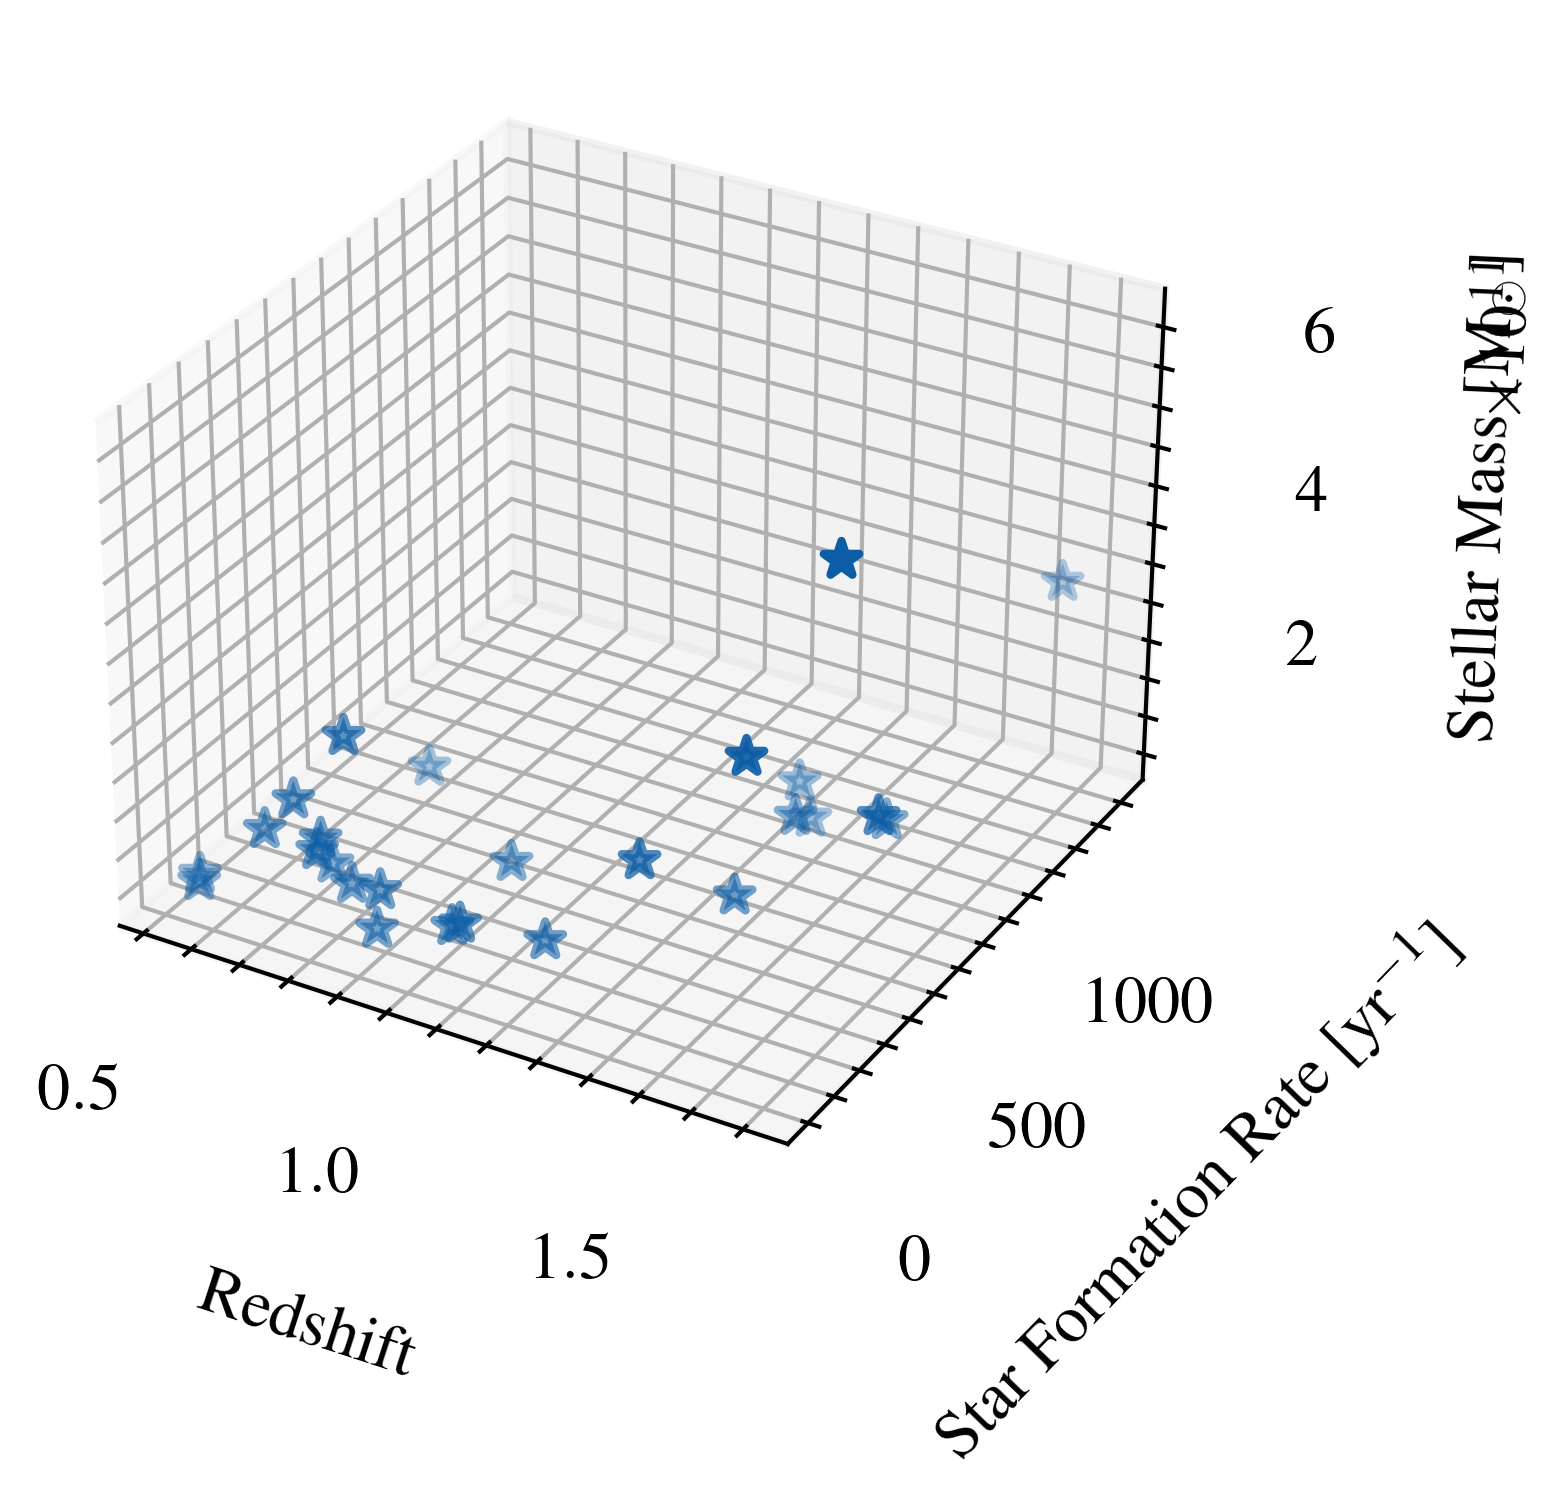

In [25]:
# SFR vs Mstar Plot
%matplotlib inline
plt.style.use(["ieee","science"])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['redshift'], df['SFR'], df['Stellar_mass'], marker = '*')
ax.set_zlabel("Stellar Mass [M$_\odot$]")
ax.set_ylabel("Star Formation Rate [yr$^{-1}$]")
ax.set_xlabel("Redshift")
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.legend()


In [28]:
df.sort_values(by=['Stellar_mass'])

,id,SFR,SFR_err,Stellar_mass,Stellar_mass_err,reduced_chi_square,sSFR,sSFR_err,sSFR_gyr,sSFR_err_gyr,redshift,spec_z,Age,sSFR_MS,n,re,bcg_type
15,XMM_z_1.0,65.761578,22.044591,5.580171e+10,1.894427e+10,6.436920,1.178487e-09,5.622600e-10,1.178487,0.562260,0.535235,1,8.176024,0.255494,0.7,2.3,2
19,ES1_z_0.88,16.339344,1.017821,6.758220e+10,9.687966e+09,2.009905,2.417699e-10,3.778875e-11,0.241770,0.037789,0.563950,1,7.983972,0.269210,NaN,NaN,1
4,ES1_z_0.99b,36.365577,11.760642,7.119149e+10,2.409869e+10,1.009473,5.108135e-10,2.391424e-10,0.510814,0.239142,0.918860,1,6.083441,0.489604,1.2,5.3,1
3,ES1_z_0.99,152.570824,142.756763,7.522039e+10,9.566821e+09,1.244926,2.028317e-09,1.915299e-09,2.028317,1.915299,1.193720,1,5.052398,0.736680,1.1,6.3,2
7,ES1_z_1.40,785.503591,97.363627,7.781236e+10,1.121162e+10,5.085912,1.009484e-08,1.918666e-09,10.094843,1.918666,1.400000,0,4.448673,0.974689,0.9,3.8,2
24,XMM-19,78.394902,3.919745,8.740998e+10,4.867738e+09,5.393139,8.968644e-10,6.712248e-11,0.896864,0.067122,1.047890,1,5.561858,0.596334,NaN,NaN,1
5,ES1_z_1.04,312.219795,148.304865,9.512975e+10,1.959103e+10,5.153100,3.282042e-09,1.699191e-09,3.282042,1.699191,1.040000,0,5.591708,0.589353,1.2,5.9,2
21,XMM_z_0.81,117.641453,55.926071,1.024312e+11,2.219733e+10,2.232051,1.148493e-09,6.000373e-10,1.148493,0.600037,0.782721,1,6.721117,0.393190,NaN,NaN,2
14,XMM_z_0.9,70.836925,19.586493,1.042527e+11,1.300711e+10,0.715005,6.794732e-10,2.061160e-10,0.679473,0.206116,0.849570,1,6.395702,0.438550,1.0,9.1,1
13,XMM-30,381.735158,50.399395,1.121162e+11,1.703403e+10,1.367169,3.404818e-09,6.853288e-10,3.404818,0.685329,1.450000,0,4.319611,1.039909,0.4,4.4,2


Text(0, 0.5, 'Redshift')

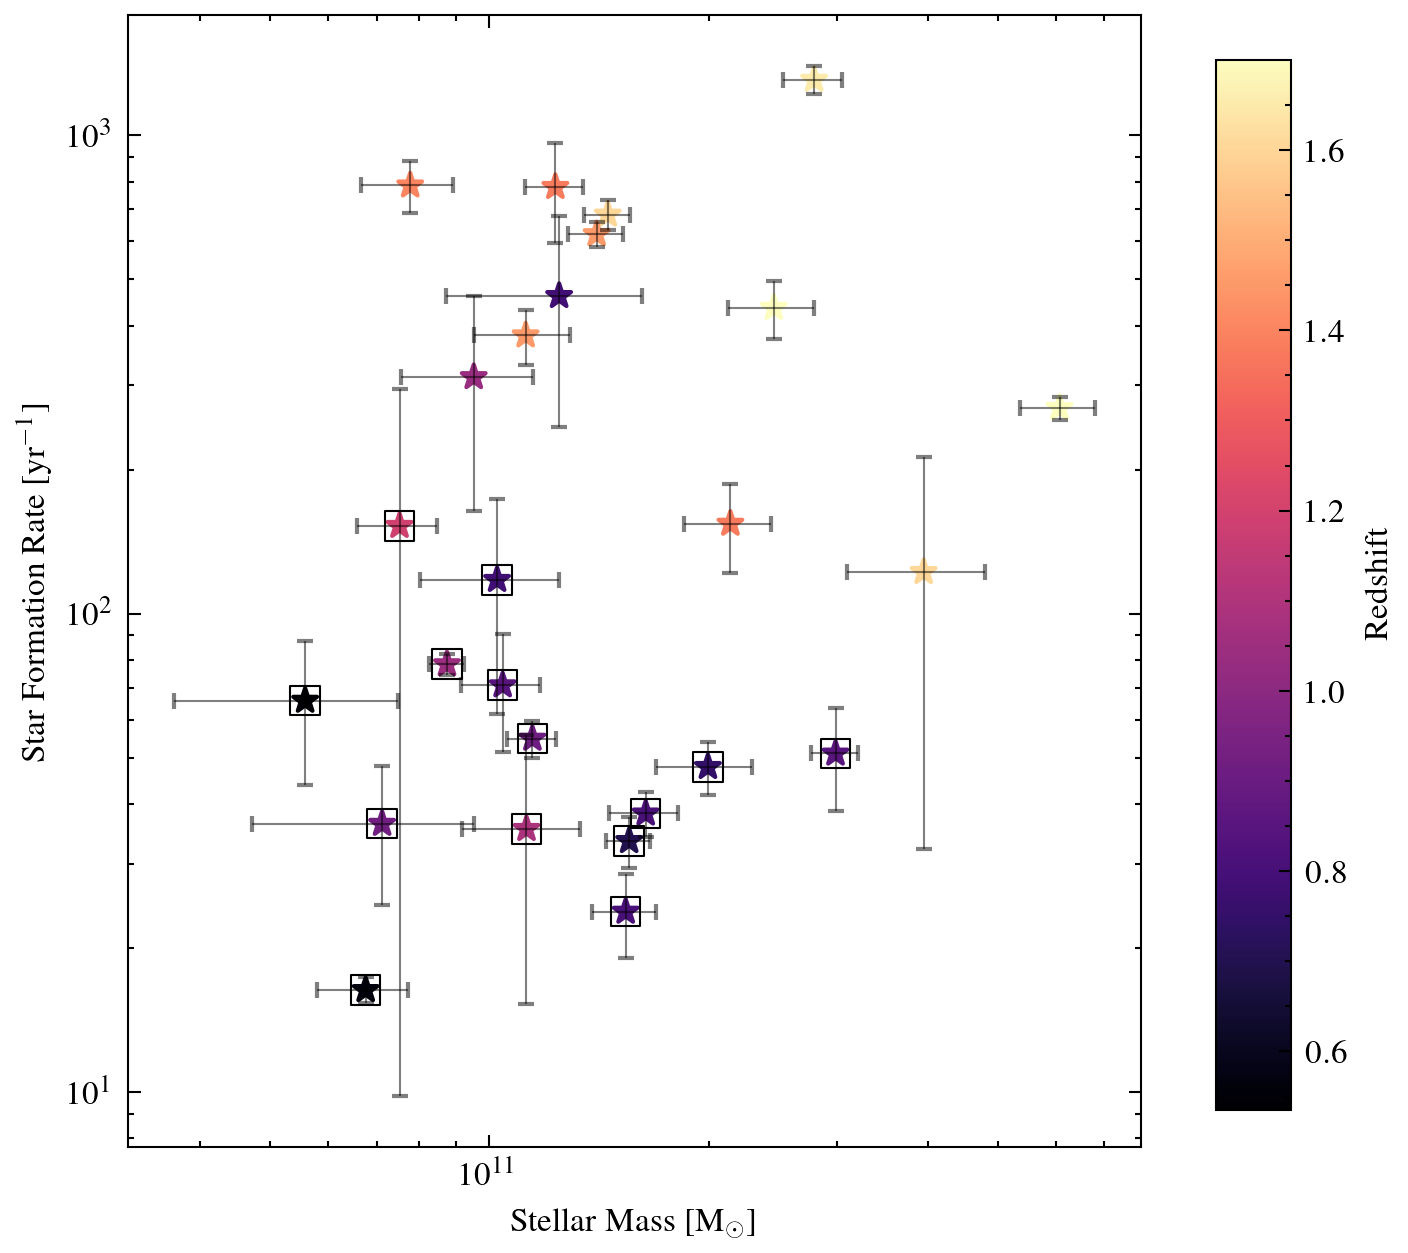

In [74]:
# SFR vs Mstar Plot
%matplotlib inline
vmin = min(master_df['redshift'])
vmax = max(master_df['redshift'])
plt.style.use(["ieee","science"])
fig, ax = plt.subplots(1,1,dpi = 300, figsize = (5,5))
im = ax.scatter(master_df['Stellar_mass'], master_df['SFR'], marker = '*',facecolors='none', c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = 'magma')
ax.errorbar(master_df['Stellar_mass'], master_df['SFR'], xerr=master_df['Stellar_mass_err'],
yerr=master_df['SFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=2, elinewidth = 0.5)
specz = master_df[master_df['spec_z'] == 1]
ax.scatter(specz['Stellar_mass'], specz['SFR'], marker = 's', color = 'black', facecolors= 'none', lw = 0.5, s = 50, label = 'Spec_z')
ax.set_xlabel("Stellar Mass [M$_\odot$]")
ax.set_ylabel("Star Formation Rate [yr$^{-1}$]")
ax.set_yscale('log')
ax.set_xscale('log')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("Redshift")

Text(0, 0.5, 'S/N')

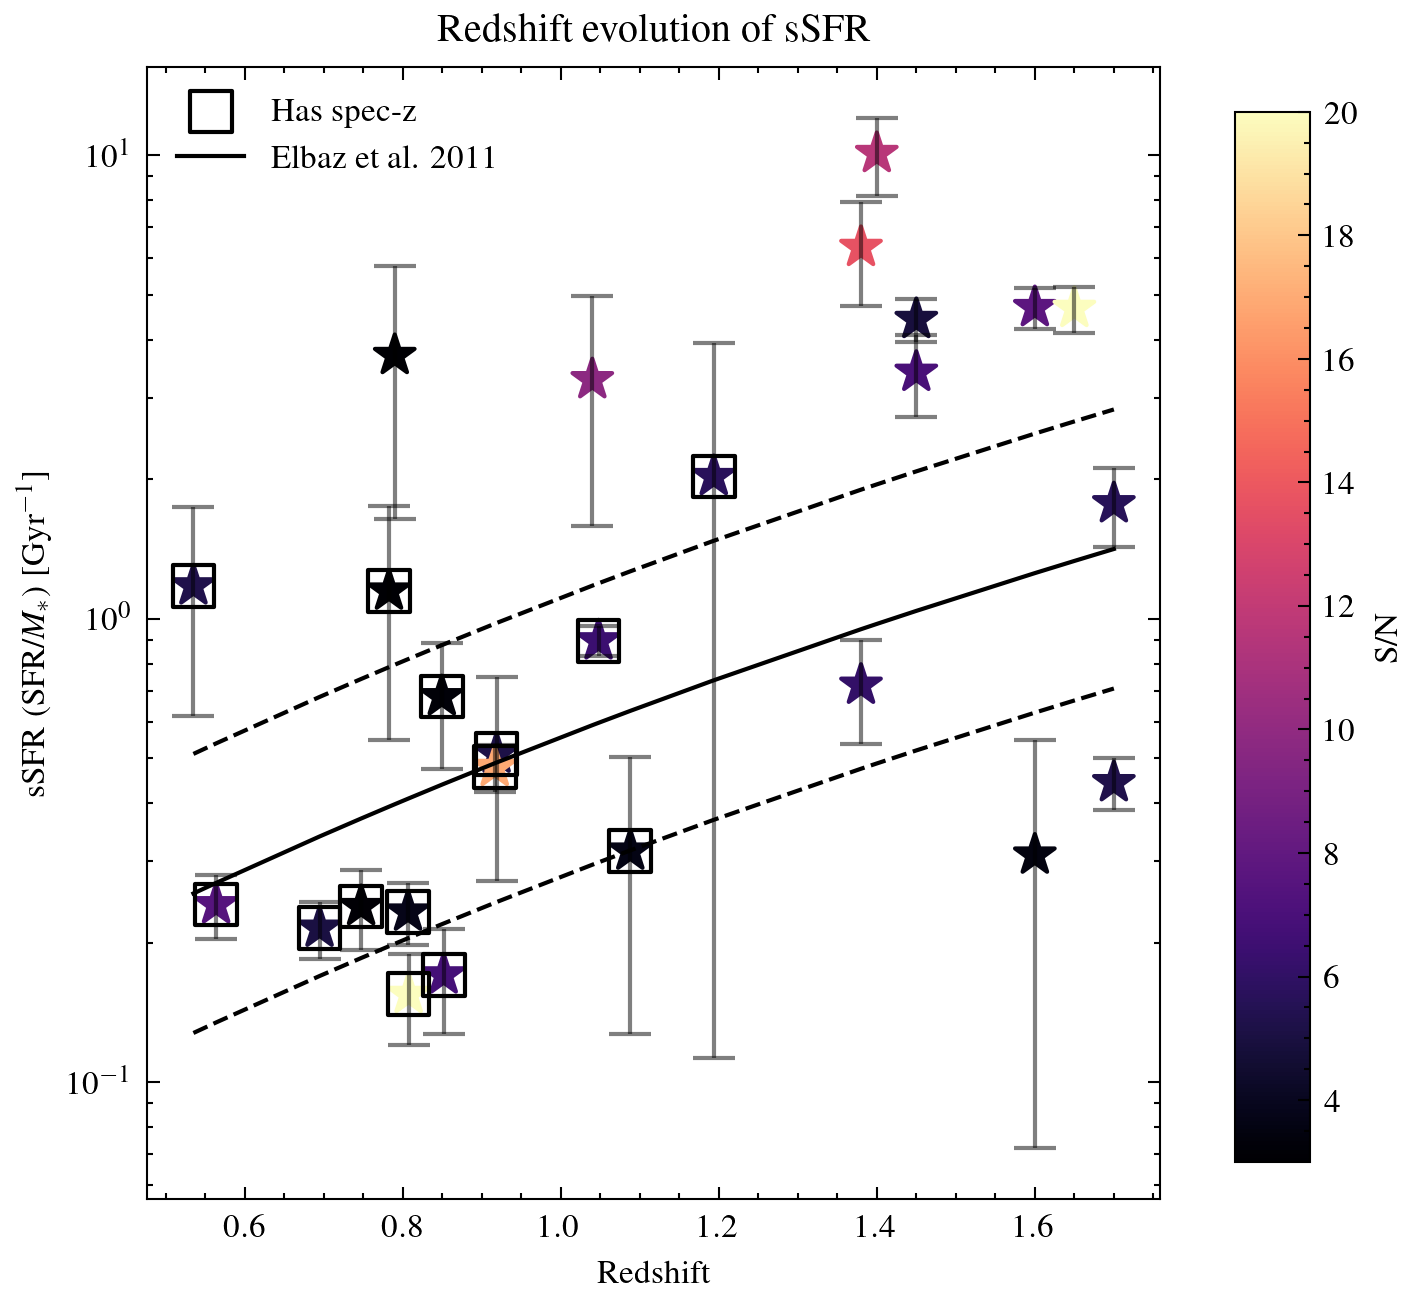

In [73]:
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (5,5))
vmin = 3
vmax = 20
im=ax.scatter(master_df['redshift'], master_df['sSFR_gyr'], c = master_df['S/N'],  marker = '*', s = 100, vmin = vmin, vmax = vmax, cmap = 'magma')
ax.errorbar(master_df['redshift'], master_df['sSFR_gyr'], yerr = master_df['sSFR_err_gyr'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
# for i, txt in enumerate(ms_results['index']):
#     ax[0].annotate(txt, (ms_results['redshift'][i], ms_results['sSFR_gyr'][i] - 0.04))
# ax.scatter(sb_results['redshift'], sb_results['sSFR_gyr'], color = 'purple', marker = '*',facecolors='none')
# ax.errorbar(sb_results['redshift'], sb_results['sSFR_gyr'], yerr = sb_results['sSFR_err_gyr'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
# for i, txt in enumerate(sb_results['index']):
#     ax[0].annotate(txt, (sb_results['redshift'][i], sb_results['sSFR_gyr'][i]- 0.04))
ax.set_yscale('log')

# ax[0].scatter(nr_data['redshift'], nr_data['sSFR_gyr'], marker = 'o', facecolors = 'none', color = 'green', linewidth = 1, s = 200)
ax.scatter(specz['redshift'], specz['sSFR_gyr'], marker = 's', color = 'black', linewidth = 1, label = 'Has spec-z', facecolors = 'none', s = 100)
# ax.scatter(sb_specz['redshift'], sb_specz['sSFR_gyr'], marker = '*', color = 'purple', linewidth = 1)
ax.set_ylabel("sSFR (SFR/$M_*$) [Gyr$^{-1}$]")
ax.set_xlabel("Redshift")
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']), color = 'black', linewidth = 1, label = 'Elbaz et al. 2011')
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']*2), color = 'black', ls = "--", linewidth = 1)
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']/2), color = 'black', ls = "--", linewidth = 1)
ax.set_title("Redshift evolution of sSFR")
ax.legend()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("S/N")
# plt.legend()
# fig.savefig("/Users/arames52/Desktop/ssfr_z_sed.jpg", dpi = 300)

Text(0, 0.5, 'S/N')

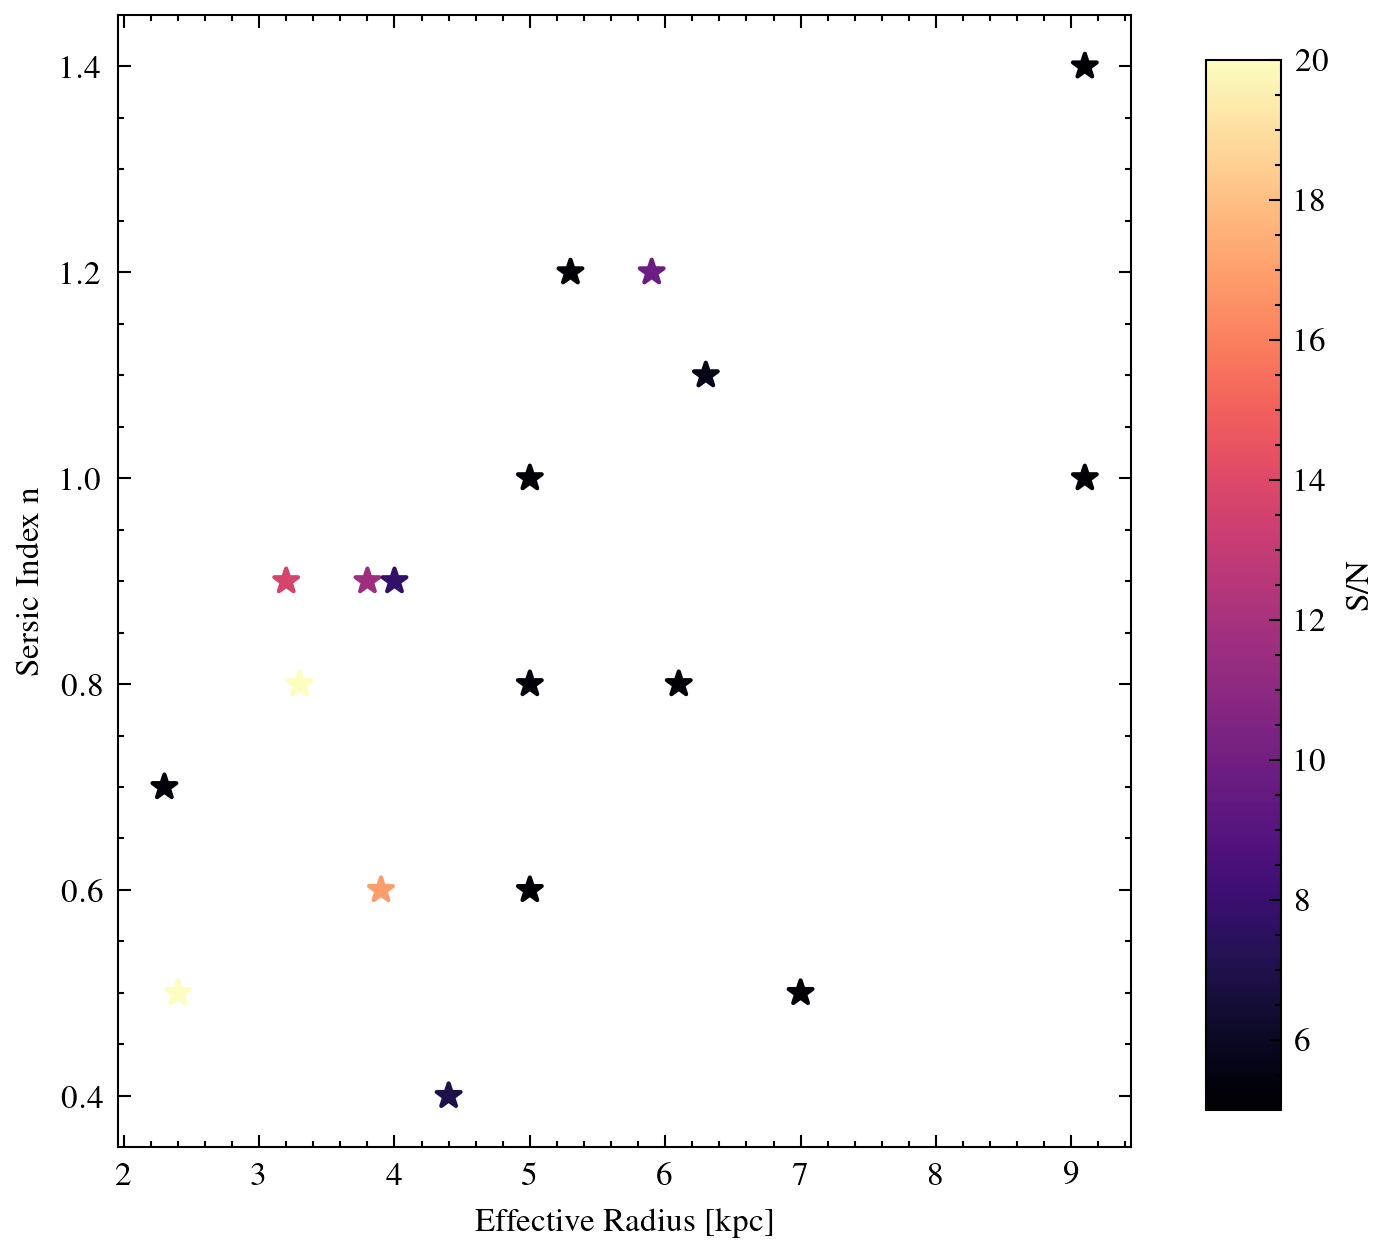

In [78]:
%matplotlib inline
vmin = 5
vmax = 20
plt.style.use(["ieee","science"])
fig, ax = plt.subplots(1,1,dpi = 300, figsize = (5,5))
im = ax.scatter(master_df['re'], master_df['n'], marker = '*',facecolors='none', c = master_df['S/N'], vmin = vmin, vmax = vmax, cmap = 'magma')
# ax.errorbar(master_df['Stellar_mass'], master_df['SFR'], xerr=master_df['Stellar_mass_err'],
# yerr=master_df['SFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=2, elinewidth = 0.5)
# specz = master_df[master_df['spec_z'] == 1]
# ax.scatter(specz['Stellar_mass'], specz['SFR'], marker = 's', color = 'black', facecolors= 'none', lw = 0.5, s = 50, label = 'Spec_z')
ax.set_xlabel("Effective Radius [kpc]")
ax.set_ylabel("Sersic Index n")
# ax.set_yscale('log')
# ax.set_xscale('log')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("S/N")

# Hodge SMGs

In [80]:
from uncertainties import ufloat
from uncertainties.umath import *
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
smg_sm = pd.read_csv("/Users/arames52/Research/Data/aless_smgs.txt", names = ["id", "MH", "z"], delim_whitespace=True)
def mh_to_mstar(mh):
    log_mstar = (ufloat(-0.393, 0.002) * mh) + ufloat(1.22, 0.04)
    return log_mstar
smg_morph = pd.read_csv("/Users/arames52/Research/Data/hodge_smg.txt", names=["id", "Re", "n"], 
                       delim_whitespace=True)
mh_arr = list(smg_sm['MH'])
hodge_smg = smg_sm.merge(smg_morph)
hodge_smg['mstar'] = mh_to_mstar(hodge_smg['MH'])
stellar_mass = []
stellar_mass_err = []
for ind, row in hodge_smg.iterrows():
    stellar_mass.append(row['mstar'].n)
    stellar_mass_err.append(row['mstar'].std_dev)
hodge_smg['stellar_mass'] = stellar_mass
hodge_smg['stellar_mass_err'] = stellar_mass_err
hodge_smg['Re_kpc'] = (cosmo.kpc_proper_per_arcmin(np.array(hodge_smg['z']))*(np.array(hodge_smg['Re']))/60).value
hodge_smg['rest_wave'] = 0.87/(1 + hodge_smg['z'])
hodge_smg['median_SFR'] = 500

In [81]:
etg = pd.read_csv("/Users/arames52/Research/Data/mnras0382-0109-SD1.csv")
# etg = etg[etg['z'].between(0.7,1.7)]
etg['re'] = etg['ae']*np.sqrt(1-etg['epsilon'])
etg['re_kpc'] = (cosmo.kpc_proper_per_arcmin(np.array(etg['z']))*(np.array(etg['re']))/60).value
etg['stellar_mass_log'] = np.log10(np.array(etg['stellar_mass'])*10**10)
etg['rest_wave'] = 0.00081/(1+etg['z'])
hst_bcgs = pd.read_csv("/Users/arames52/Downloads/table2.dat.txt", delim_whitespace=True, names = ["name", "class", "model", "mag", 
                                                                                                  "mean_sb", "re", "n", "b/a", "pa", 
                                                                                                   "align"])
hst_bcgs_tab1 = pd.read_csv("/Users/arames52/Downloads/table1.dat.txt", delim_whitespace=True, names = ["name", "ra",
                                                    "dec", "z", "class", "inst", "filter", "scale", "color"])
hst_bcgs_mass = pd.read_csv("/Users/arames52/Research/Data/hst_bcgs_mass.dat.txt", delim_whitespace = True, names = ["name", "ra", "dec", "r_pos",
                                                                                                                    "M200", "E_M200", "e_M200", "Method", "r-M200",
                                                                                                                    "PAcl", "e_PAcl","r"])
hst_bcgs_mass = hst_bcgs_mass[["name", "M200", "e_M200"]]
hst_bcgs = hst_bcgs.merge(hst_bcgs_tab1, on = "name")
hst_bcgs = hst_bcgs.merge(hst_bcgs_mass, on = "name")
hst_bcgs = hst_bcgs[hst_bcgs['model'] == "Sersic"]
# hst_bcgs = hst_bcgs[hst_bcgs['z'].between(0.7,1.7, inclusive = "both")]
# np.unique(hst_bcgs['filter'])
# hst_filters = {"F105W" : 1055.2, "F125W" : 1248.6, "F140W" : 1392.3, "F160W": 1536.9, "F814W": 8115.3, "F850LP":9145.2}
# hst_bcgs['rest_wave'] = 0
# for ind, row in hst_bcgs.iterrows():
#     hst_bcgs.loc[ind, 'rest_wave'] = hst_filters[row['filter']]*1e-6 / (1+ row['z'])